<a href="https://colab.research.google.com/github/SamHarless/Codeathon1/blob/main/Sam_Harless_Copy_of_CS_4774_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://www.travelinusa.us/wp-content/uploads/sites/3/2017/11/Painted-Ladies-San-Francisco-01.jpg).

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture on K-means or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment.

<class 'numpy.ndarray'>
16512
[ 1.05320006 -0.77840904 -1.63530331  4.35210079  3.28048089  3.85528793
  3.1946254   0.58177957 -0.42462433  0.          1.          0.
  0.          0.        ]
<class 'numpy.ndarray'>


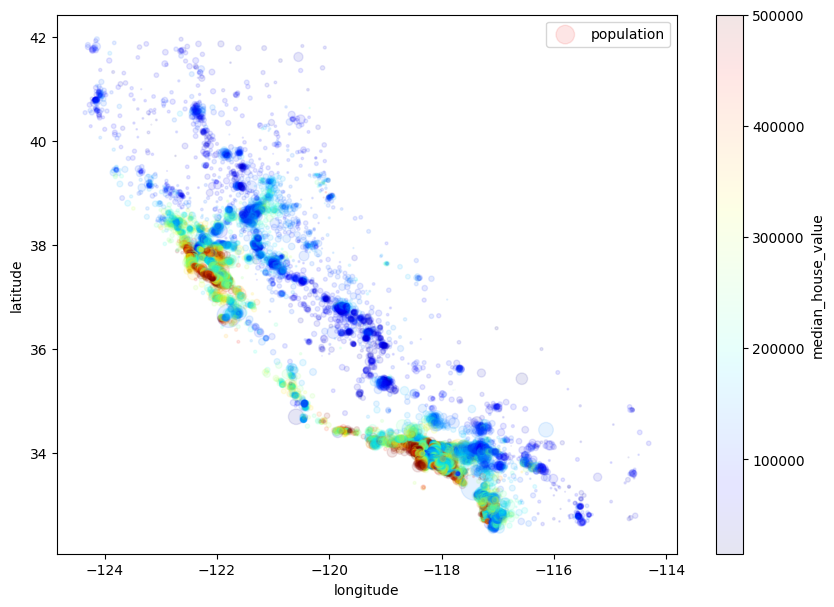

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


np.random.seed(42)
# Your code goes here for this section.

rawData=pd.read_csv('housing.csv')

#print(rawData.info())

#print(rawData.describe())

rawData.plot(kind="scatter", x="longitude", y="latitude", alpha=.1, s=rawData["population"]/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)


categoricalColumns = rawData.select_dtypes(exclude='number').columns.tolist()
numericalColumns = rawData.select_dtypes(include='number').columns.tolist()
#got the select_dtypes() method from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html

numericalPipeline= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

categoricalPipeline = Pipeline([
    ("onehot", OneHotEncoder())
])

fullPipeline = ColumnTransformer([
    ("numerical", numericalPipeline, numericalColumns),
    ("categorical", categoricalPipeline, categoricalColumns)
])


trainSet, testSet = train_test_split(rawData, test_size=.2, random_state=42)

cleanedTrainSet=fullPipeline.fit_transform(trainSet)

cleanedTestSet=fullPipeline.fit_transform(testSet)

print(type(cleanedTrainSet))

print(len(cleanedTrainSet))

print(cleanedTrainSet[69])

print(type(cleanedTrainSet[69]))




- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).

import random

class KMeans:

  def __init__(self, kIn):

    self.k=kIn
    self.distanceType='manhattan'
    self.centroidDict=None

  def distanceCalc(self, vector1, vector2, distType):
    if distType == 'euclidean':
        return self.eDist(vector1, vector2)
    elif distType == 'manhattan':
        return self.manhattanDist(vector1, vector2)
    else:
        return self.supDist(vector1, vector2)



  def manhattanDist(self, vector1, vector2):
    sum=0

    for i in range(len(vector1)):
      sum+= abs(vector1[i]-vector2[i])

    return sum

  def eDist(self, vector1, vector2):

    squared_distance = 0
    for i in range(len(vector1)):
        squared_distance += (vector1[i] - vector2[i]) ** 2

    distance = np.sqrt(squared_distance)

    return distance

  def supDist(self, vector1, vector2):
    #https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

    return np.linalg.norm(vector1-vector2, ord=np.inf)

  def chooseRandomUnique(self, length, numToChoose):
    availNumbers=set(range(0,length))

    if numToChoose > len(availNumbers):
      return None

    return random.sample(availNumbers, numToChoose)#does sampling without replacement, so it will be K unique random numbers
    #https://www.geeksforgeeks.org/python-random-sample-function/

  def createKCentroids(self, data):
    randomIndexs= self.chooseRandomUnique(len(data), self.k)

    centroidDict={}
    for index in randomIndexs:
      centroidDict[tuple(data[index])] = []

    #print(centroidDict)
    self.centroidDict= centroidDict

  def assignToNearestCentroid(self, data, centroidDict):

    index = 0
    while index < len(data): #loop through every piece of data\

      minDist=float('inf')
      bestKey= None
      for key in centroidDict:
        currDist=self.distanceCalc(vector1=np.array(key), vector2=data[index], distType=self.distanceType)
        if minDist > currDist:

          minDist=currDist
          bestKey=key

      centroidDict[tuple(bestKey)].append(data[index])
      index+=1


    #for key in centroidDict:
      #print(key, len(centroidDict[key]))

    self.centroidDict = centroidDict


  def recalculateCentroids(self, data, centroidDict):

    newCentroids=[]

    for key in centroidDict:

      average=np.mean(centroidDict[key], axis=0) #https://numpy.org/doc/stable/reference/generated/numpy.mean.html
      newCentroids.append(average)

    tempDict={}
    for key in newCentroids:
      tempDict[tuple(key)] = []

    #print(tempDict)

    self.centroidDict=tempDict
    return

  def actuallyDoKMeans(self, data):

    self.createKCentroids(data)

    lastIterCentroids= None
    counter = 0
    while True:

      self.assignToNearestCentroid(data, self.centroidDict)

      self.recalculateCentroids(data, self.centroidDict)

      if self.centroidDict == lastIterCentroids:
        self.assignToNearestCentroid(data, self.centroidDict)
        break

      else:
        if counter >= 50 and counter % 50 == 0:

          print(lastIterCentroids, self.centroidDict)

        counter+=1
        lastIterCentroids = self.centroidDict





myKMeans = KMeans(2)

myKMeans.createKCentroids(cleanedTrainSet)

myKMeans.assignToNearestCentroid(cleanedTrainSet, myKMeans.centroidDict)

myKMeans.recalculateCentroids(cleanedTrainSet, myKMeans.centroidDict)

myKMeans.actuallyDoKMeans(cleanedTrainSet)

<ipython-input-48-89d6aabbc467>:56: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(availNumbers, numToChoose)#does sampling without replacement, so it will be K unique random numbers
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: ignored

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [ ]:
# Your code goes here


# Your paragraph goes here for this section

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge.



- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!